In [1]:
# %load ../uoicorr_imports.py
import h5py

import numpy as np
import matplotlib.pyplot as plt

import sys, os, pdb
t
# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
    parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
    sys.path.append(p)

import subprocess
hname = subprocess.check_output('hostname')

if 'ankitnse'.encode() in hname:

    if '%s/uoicorr' % p not in sys.path:
        sys.path.append('%s/uoicorr' % p)
    if '%s/PyUoI' % p not in sys.path:
        sys.path.append('%s/PyUoI' % p)

else:
    # And standard list of subdirectories
    if '%s\\pyuoi' % p not in sys.path:
        sys.path.append('%s\\pyuoi' % p)
    if '%s\\uoicorr' % p not in sys.path:
        sys.path.append('%s\\uoicorr' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

In [2]:
l1_ratios = [0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1]

In [3]:
uoi1 = UoI_Lasso(normalize=True,
        n_boots_sel=100,
        n_boots_est=48,
        estimation_score= 'r2',
        stability_selection = 1,
        est_reg = 0)
uoi2 = UoI_ElasticNet(
        normalize=True,
        n_boots_sel= 100,
        n_boots_est= 48,
        alphas = l1_ratios,
        estimation_score= 'r2',
        warm_start = False,
        stability_selection= 1,
        est_reg = 0
        )

In [4]:
from utils import gen_covariance, gen_beta, gen_data

In [5]:
sigma = gen_covariance('block', correlation = 0)

In [6]:
beta = gen_beta(sparsity = 0.8)

In [7]:
X, X_test, y, y_test = gen_data(covariance = sigma, beta = beta)

In [8]:
uoi2.fit(X, y)

UoI_ElasticNet(alphas=[0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1], comm=None,
        copy_X=True, eps=0.001, est_reg=None, estimation_frac=0.9,
        estimation_score='r2', fit_intercept=True, max_iter=None,
        n_boots_est=48, n_boots_sel=100, n_lambdas=48, normalize=True,
        random_state=None, selection_frac=0.9, stability_selection=1,
        warm_start=False)

In [9]:
uoi1.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, est_reg=None,
     estimation_frac=0.9, estimation_score='r2', fit_intercept=True,
     max_iter=None, n_boots_est=48, n_boots_sel=100, n_lambdas=48,
     normalize=True, random_state=None, selection_frac=0.9,
     stability_selection=1, warm_start=None)

In [15]:
# Assemble the set of supports that correspond to l1_ratio = 1
l1_supports = []
l1_idx = []
for i in range(uoi2.supports_.shape[0]):
    if uoi2.support_reg_ids_[i][0]['l1_ratio'] == 1:
        l1_supports.append(uoi2.supports_[i, :])
        l1_idx.append(i)
l1_supports = np.array(l1_supports)
l1_idx = np.array(l1_idx)

In [79]:
# Calculate the mutual overlap matrix between the support sets:
overlap_matrix2 = np.zeros((uoi_lasso1.supports_.shape[0], uoi_lasso2.supports_.shape[0]))
for i in range(overlap_matrix2.shape[0]):
    for j in range(overlap_matrix2.shape[1]):
        overlap_matrix2[i, j] = (1 * uoi_lasso1.supports_[i, :]) @ (1 * uoi_lasso2.supports_[j, :].T)/60

Takeaway: Even with a 1000 selection bootstraps, there is still residual variability in the selected supporty sets between two different instantions of Lasso on the same data. This is true even in the absence of correlations. 

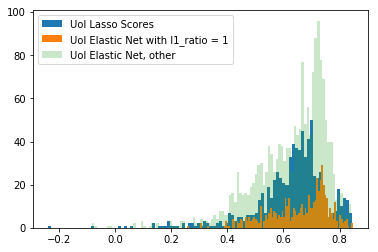

In [18]:
plt.hist(uoi1.scores_.flatten(), bins = 100)
plt.hist(uoi2.scores_[:, l1_idx].flatten(), bins = 100)
plt.hist(uoi2.scores_[:, np.setdiff1d(np.arange(uoi2.scores_.shape[1]), l1_idx)].flatten(), bins = 100, alpha = 0.25)
plt.legend(['UoI Lasso Scores', 'UoI Elastic Net with l1_ratio = 1', 'UoI Elastic Net, other'])

The distribution of scores are nearly the same for UoI Elastic Net l1_ratio = 1, UoI Lasso, UoI Elastic Net l1_ratio != 1. Therefore, even at this stage, we have not clearly resolved why the performance of the two algorithms are so similar. The next step is to then look at the best scoring supports across each bootstrap:

In [44]:
est_l1_idx = []
notest_l1_idx = []

l1_rp_max_idx = []
notl1_rp_max_idx = []

for i, max_idx in enumerate(uoi2.rp_max_idx_):
    if max_idx in l1_idx:
        l1_rp_max_idx.append(max_idx)
        est_l1_idx.append(i)
    else: 
        notl1_rp_max_idx.append(max_idx)
        notest_l1_idx.append(i)

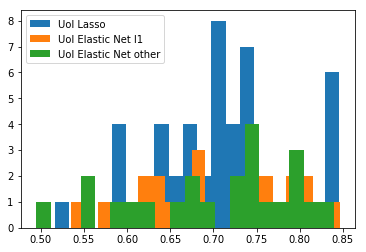

In [50]:
plt.hist(uoi1.scores_[np.arange(48), uoi1.rp_max_idx_], bins = 20)
plt.hist(uoi2.scores_[est_l1_idx, l1_rp_max_idx], bins = 20)
plt.hist(uoi2.scores_[notest_l1_idx, notl1_rp_max_idx], bins = 20)
plt.legend(['UoI Lasso', 'UoI Elastic Net l1', 'UoI Elastic Net other'])

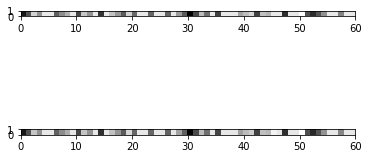

In [53]:
# What are the resulting estimates once we take the median?
fig, ax = plt.subplots(2, 1)
ax[0].set_aspect('equal')
ax[0].pcolor(uoi1.coef_[np.newaxis, :], cmap = 'Greys')
ax[1].set_aspect('equal')
ax[1].pcolor(uoi2.coef_[np.newaxis, :], cmap = 'Greys')

In [57]:
np.dot(uoi1.coef_/np.linalg.norm(uoi1.coef_), uoi2.coef_.T/np.linalg.norm(uoi2.coef_))

0.9993137844759135

In [61]:
best_estimates1 = uoi1.estimates_[np.arange(uoi1.n_boots_est),
                                 uoi1.rp_max_idx_, :]
best_estimates_enl1 = uoi2.estimates_[est_l1_idx, l1_rp_max_idx, :]
best_estimates_enother = uoi2.estimates_[notest_l1_idx, notl1_rp_max_idx, :]

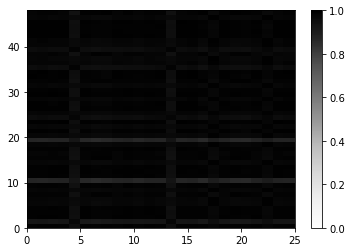

In [75]:
# Calculate similarity matrix of estimates:
est_similarity_matrix1 = np.zeros((best_estimates1.shape[0], best_estimates_enl1.shape[0]))
for i in range(est_similarity_matrix1.shape[0]):
    for j in range(est_similarity_matrix1.shape[1]):
        est_similarity_matrix1[i, j] = best_estimates1[i, :]/np.linalg.norm(best_estimates1[i, :])\
                                        @ best_estimates_enl1[j, :].T/np.linalg.norm(best_estimates_enl1[j, :])
plt.pcolor(est_similarity_matrix1, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar()

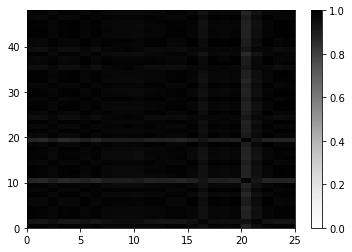

In [78]:
est_similarity_matrix2 = np.zeros((best_estimates1.shape[0], best_estimates_enother.shape[0]))
for i in range(est_similarity_matrix2.shape[0]):
    for j in range(est_similarity_matrix2.shape[1]):
        est_similarity_matrix1[i, j] = best_estimates1[i, :]/np.linalg.norm(best_estimates1[i, :])\
                                        @ best_estimates_enother[j, :].T/np.linalg.norm(best_estimates_enother[j, :])
plt.pcolor(est_similarity_matrix1, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar()

Appears as though even the estimates that originate from supports not derived from l1_ratio = 1 end up being highly similar to the lasso estimates. Contrast all this with a fit where l1_ratio = 1 is excluded

In [79]:
uoi3 = UoI_ElasticNet(
        normalize=True,
        n_boots_sel= 100,
        n_boots_est= 48,
        alphas = [0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1],
        estimation_score= 'r2',
        warm_start = False,
        stability_selection= 1,
        est_reg = 0
        )

In [80]:
uoi3.fit(X, y)

UoI_ElasticNet(alphas=[0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1], comm=None,
        copy_X=True, eps=0.001, est_reg=None, estimation_frac=0.9,
        estimation_score='r2', fit_intercept=True, max_iter=None,
        n_boots_est=48, n_boots_sel=100, n_lambdas=48, normalize=True,
        random_state=None, selection_frac=0.9, stability_selection=1,
        warm_start=False)

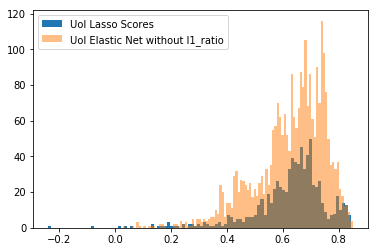

In [82]:
plt.hist(uoi1.scores_.flatten(), bins = 100)
plt.hist(uoi3.scores_.flatten(), bins = 100, alpha = 0.5)
plt.legend(['UoI Lasso Scores', 'UoI Elastic Net without l1_ratio'])

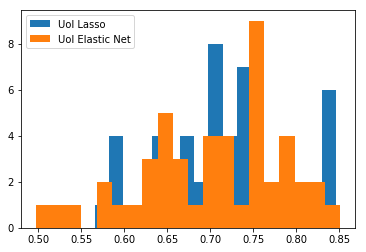

In [83]:
plt.hist(uoi1.scores_[np.arange(48), uoi1.rp_max_idx_], bins = 20)
plt.hist(uoi3.scores_[np.arange(48), uoi3.rp_max_idx_], bins = 20)
plt.legend(['UoI Lasso', 'UoI Elastic Net'])

In [84]:
# Overlap of the final coefficients
np.dot(uoi1.coef_/np.linalg.norm(uoi1.coef_), uoi3.coef_.T/np.linalg.norm(uoi3.coef_))

0.9975139862814038

In [85]:
best_estimates3 = uoi3.estimates_[np.arange(uoi3.n_boots_est),
                                 uoi3.rp_max_idx_, :]

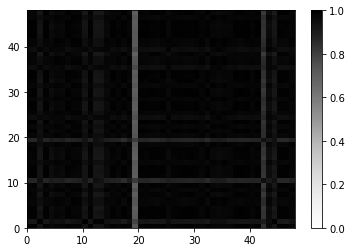

In [86]:
# Calculate similarity matrix of estimates:
est_similarity_matrix3 = np.zeros((best_estimates1.shape[0], best_estimates3.shape[0]))
for i in range(est_similarity_matrix3.shape[0]):
    for j in range(est_similarity_matrix3.shape[1]):
        est_similarity_matrix3[i, j] = best_estimates1[i, :]/np.linalg.norm(best_estimates1[i, :])\
                                        @ best_estimates3[j, :].T/np.linalg.norm(best_estimates3[j, :])
plt.pcolor(est_similarity_matrix3, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar()

In [87]:
# Compare the false negatives and false positives
fn1 = np.count_nonzero(beta[uoi1.coef_ == 0, 0])
fp1 = np.count_nonzero(uoi1.coef_[beta.ravel() == 0])

fn2 = np.count_nonzero(beta[uoi2.coef_ == 0, 0])
fp2 = np.count_nonzero(uoi2.coef_[beta.ravel() == 0])

fn3 = np.count_nonzero(beta[uoi3.coef_ == 0, 0])
fp3 = np.count_nonzero(uoi3.coef_[beta.ravel() == 0])

In [93]:
fp3

3